In [48]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import joblib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

##### Functions

In [99]:
def deserialize_data(path):
    data = joblib.load(path)
    return data

def plot_confusion_matrix(prediction, actual_data, model_clf, cmap:str, model_name:str):
    confusion_matrix_result = confusion_matrix(actual_data, prediction)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result, 
                                  display_labels=model_clf.classes_)
    
    fig, ax = plt.subplots()
    disp.plot(cmap=cmap, ax=ax)
    plt.title('Confusion Matrix - Logistic Regression')
    
    for text in ax.texts:
        text.set_color('white')
    ax.grid(False)
    plt.show()
    
    print(f"\nClassification report for {model_name}")
    print("\n", classification_report(actual_data, prediction))
    
def gridsearch_train(classifier, hyperparams: dict, CPU_unit, scoring_unit:str, train_input:pd.DataFrame, train_output:pd.DataFrame):
    estimator = GridSearchCV(
        estimator=classifier, 
        param_grid=hyperparams, 
        scoring=scoring_unit, 
        verbose=3, 
        n_jobs=CPU_unit, 
        cv=5, 
        error_score='raise'
    )
    estimator.fit(train_input, train_output)

    optimal_params = estimator.best_params_
    optimal_model = estimator.best_estimator_
    print(f"\nBest params from grid search: {optimal_params}")
    print(f"With best params, {scoring_unit} score is: {round(estimator.best_score_,2)}")
    
    return optimal_model, optimal_params

def predict_data(model_clf, test_data):
    prediction = model_clf.predict(test_data)
    return prediction

def summarize_score(prediction, actual_data, model_type:str, hyperparams):
    
    ## generate dictionary with metric results
    dict_sum = {
        "model"        : model_type,
        "hyperparams"  : str(hyperparams),
        "recall"       : recall_score(actual_data, prediction, average=None)[1],
        "precision"    : precision_score(actual_data, prediction, average=None)[1],
        "f1-score"     : f1_score(actual_data, prediction),
        "number of FN" : confusion_matrix(y_valid, prediction)[1][0]
    }
    
    return pd.DataFrame([dict_sum])

### Load Original Data

load training data

In [4]:
X_train = deserialize_data(r'E:\01_Programming\Py\dataframe_transform\modelling_data\original\X_train.pkl')
X_train

,bins_0_75,bins_1_75,bins_2_75,bins_3_75,bins_4_75,bins_5_75,bins_6_75,bins_7_75,Exit
119,0.0,0.0,5.0,13479.0,7.0,1.0,1.0,0.0,1
2836,2306.0,179.0,340.0,2132.0,3.0,0.0,0.0,2.0,1
353,142.0,106.0,2.0,2.0,3.0,1.0,1.0,16.0,1
2024,907.0,7.0,2.0,4.0,3.0,1.0,2.0,1344.0,1
48,254.0,27.0,3.0,3.0,1.0,0.0,1.0,22.0,1
...,...,...,...,...,...,...,...,...,...
2293,1110.0,807.0,1677.0,1.0,1.0,0.0,1.0,12.0,0
3474,0.0,0.0,15.0,5647.0,12.0,0.0,0.0,2.0,0
1901,1.0,1.0,30.0,8868.0,48.0,2.0,2.0,2.0,1
1252,2934.0,51.0,2.0,4.0,1.0,0.0,0.0,20.0,1


In [5]:
y_train = deserialize_data(r"E:\01_Programming\Py\dataframe_transform\modelling_data\original\y_train.pkl")
y_train

119     0
2836    0
353     0
2024    0
48      0
       ..
2293    1
3474    1
1901    0
1252    0
1478    0
Name: outcome, Length: 2676, dtype: int64

load validation data

In [6]:
X_valid = deserialize_data(r'E:\01_Programming\Py\dataframe_transform\modelling_data\original\X_valid.pkl')
X_valid

,bins_0_75,bins_1_75,bins_2_75,bins_3_75,bins_4_75,bins_5_75,bins_6_75,bins_7_75,Exit
3299,2349.0,107.0,320.0,2239.0,22.0,0.0,0.0,0.0,1
2494,1298.0,189.0,351.0,1684.0,4.0,0.0,0.0,1.0,1
2232,1816.0,9.0,2.0,3.0,2.0,0.0,1.0,2485.0,1
2227,1.0,2.0,62.0,7249.0,93.0,2.0,1.0,3.0,1
1892,1168.0,9.0,2.0,4.0,3.0,1.0,2.0,1543.0,1
...,...,...,...,...,...,...,...,...,...
2292,68.0,3371.0,285.0,979.0,7.0,0.0,0.0,0.0,1
934,141.0,149.0,5.0,29.0,2.0,0.0,1.0,20.0,1
1439,52.0,206.0,48.0,42.0,7726.0,32.0,53.0,93.0,0
2770,1275.0,120.0,3.0,5.0,2.0,1.0,0.0,16.0,0


In [7]:
y_valid = deserialize_data(r'E:\01_Programming\Py\dataframe_transform\modelling_data\original\y_valid.pkl')
y_valid

3299    0
2494    0
2232    0
2227    0
1892    0
       ..
2292    1
934     0
1439    1
2770    1
1274    0
Name: outcome, Length: 334, dtype: int64

load test data

In [8]:
X_test = deserialize_data(r'E:\01_Programming\Py\dataframe_transform\modelling_data\original\X_test.pkl')
X_test

,bins_0_75,bins_1_75,bins_2_75,bins_3_75,bins_4_75,bins_5_75,bins_6_75,bins_7_75,Exit
3425,0.0,1.0,264.0,3368.0,5.0,0.0,0.0,0.0,0
1948,1119.0,7.0,3.0,4.0,4.0,2.0,2.0,1600.0,1
844,64.0,1786.0,4.0,5.0,2.0,1.0,1.0,20.0,1
86,0.0,135.0,521.0,3921.0,8.0,0.0,1.0,1.0,0
335,218.0,22.0,1.0,3.0,3.0,1.0,1.0,21.0,1
...,...,...,...,...,...,...,...,...,...
1217,722.0,520.0,70.0,25.0,4.0,2.0,1.0,18.0,0
3451,0.0,5.0,260.0,2128.0,18.0,1.0,0.0,0.0,0
141,76.0,397.0,796.0,19.0,1.0,0.0,0.0,15.0,0
1808,893.0,47.0,3.0,3.0,1.0,0.0,12.0,1980.0,1


In [9]:
y_test = deserialize_data(r'E:\01_Programming\Py\dataframe_transform\modelling_data\original\y_test.pkl')
y_test

3425    1
1948    0
844     0
86      1
335     0
       ..
1217    1
3451    1
141     1
1808    0
3150    0
Name: outcome, Length: 335, dtype: int64

#### Dependencies for modelling

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

## Modelling Dummy Classifier

In [11]:
clf_dummy = DummyClassifier(strategy='most_frequent', random_state=42)
clf_dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [12]:
dummy_prediction_valid = clf_dummy.predict(X_valid)
print(classification_report(y_valid, dummy_prediction_valid))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       168
           1       0.00      0.00      0.00       166

    accuracy                           0.50       334
   macro avg       0.25      0.50      0.33       334
weighted avg       0.25      0.50      0.34       334


E:\01_Programming\Py\dataframe_transform\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\dataframe_transform\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\dataframe_transform\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Modelling

In [13]:
rand_state = 42

## 1 - Linear Classifier

### Logistic Regression

In [25]:
logreg_clf = LogisticRegression(random_state=rand_state)
logreg_clf.fit(X_train, y_train)

E:\01_Programming\Py\dataframe_transform\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [26]:
logreg_prediction_valid = logreg_clf.predict(X_valid)

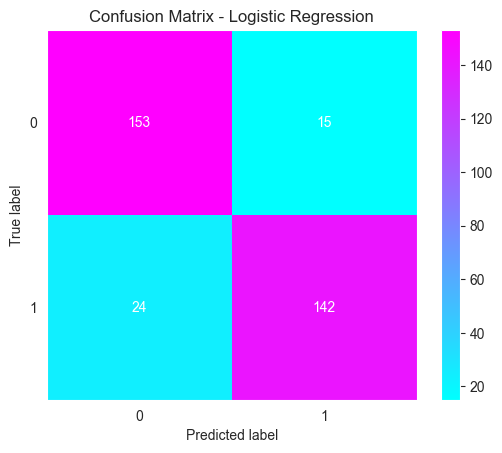


Classification report for logistic regression

               precision    recall  f1-score   support

           0       0.86      0.91      0.89       168
           1       0.90      0.86      0.88       166

    accuracy                           0.88       334
   macro avg       0.88      0.88      0.88       334
weighted avg       0.88      0.88      0.88       334


In [27]:
plot_confusion_matrix(logreg_prediction_valid, y_valid, logreg_clf, 'cool', "logistic regression")

hyperparameter tuning - logistic regression

hyperparam 1

In [100]:
logreg_params1 = {
    "penalty"   : ["l1", "l2"],
    "solver"    : ["liblinear"],
    "C"         : [1, 10, 100, 1000]
}

In [101]:
neutral_logreg = LogisticRegression

In [102]:
logreg_GS1, logreg_hparams1 = gridsearch_train(LogisticRegression(), logreg_params1, scoring_unit="recall", CPU_unit=4, train_input=X_train, train_output=y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params from grid search: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
With best params, recall score is: 0.83


In [103]:
logreg_GS1_predict = predict_data(logreg_GS1, X_valid)

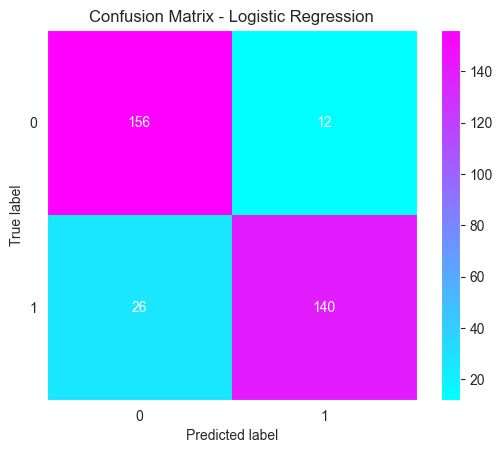


Classification report for Logistic Regression - GS1

               precision    recall  f1-score   support

           0       0.86      0.93      0.89       168
           1       0.92      0.84      0.88       166

    accuracy                           0.89       334
   macro avg       0.89      0.89      0.89       334
weighted avg       0.89      0.89      0.89       334


In [104]:
plot_confusion_matrix(logreg_GS1_predict, y_valid, logreg_GS1, cmap='cool', model_name="Logistic Regression - GS1")

In [105]:
logreg_GS1_df = summarize_score(logreg_GS1_predict, y_valid, "logreg GS1", logreg_hparams1)
logreg_GS1_df

,model,hyperparams,recall,precision,f1-score,number of FN
0,logreg GS1,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.843373,0.921053,0.880503,26


Hyper param 2

In [106]:
logreg_params1_1 = {
    "penalty"   : ["l2"],
    "solver"    : ["liblinear"],
    "C"         : [80, 110, 150]
}

In [107]:
logreg_GS2, logreg_hparams2 = gridsearch_train(logreg_clf, logreg_params1_1, scoring_unit="recall", CPU_unit=4, train_input=X_train, train_output=y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best params from grid search: {'C': 110, 'penalty': 'l2', 'solver': 'liblinear'}
With best params, recall score is: 0.83


In [108]:
logreg_GS2_predict = predict_data(logreg_GS2, X_valid)

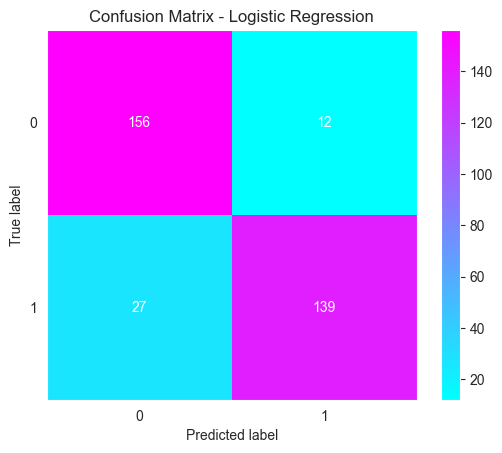


Classification report for Logistic Regression - GS2

               precision    recall  f1-score   support

           0       0.85      0.93      0.89       168
           1       0.92      0.84      0.88       166

    accuracy                           0.88       334
   macro avg       0.89      0.88      0.88       334
weighted avg       0.89      0.88      0.88       334


In [109]:
plot_confusion_matrix(logreg_GS2_predict, y_valid, logreg_GS2, cmap='cool', model_name="Logistic Regression - GS2")

In [110]:
logreg_GS2_df = summarize_score(logreg_GS2_predict, y_valid, "logreg GS2", logreg_hparams2)
logreg_GS2_df

,model,hyperparams,recall,precision,f1-score,number of FN
0,logreg GS2,"{'C': 110, 'penalty': 'l2', 'solver': 'libline...",0.837349,0.92053,0.876972,27


Hyper Param 3

In [111]:
logreg_params3 = {
    "penalty": ["l2", None],
    "solver": ["sag", "saga", "newton-cg"],
    "C": [1, 10, 100, 250,500, 1000],
}

In [112]:
logreg_GS3, logreg_hparams3  = gridsearch_train(logreg_clf, logreg_params3, scoring_unit="recall", CPU_unit=4, train_input=X_train, train_output=y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best params from grid search: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
With best params, recall score is: 0.83


In [113]:
logreg_GS3_predict = predict_data(logreg_GS3, X_valid)

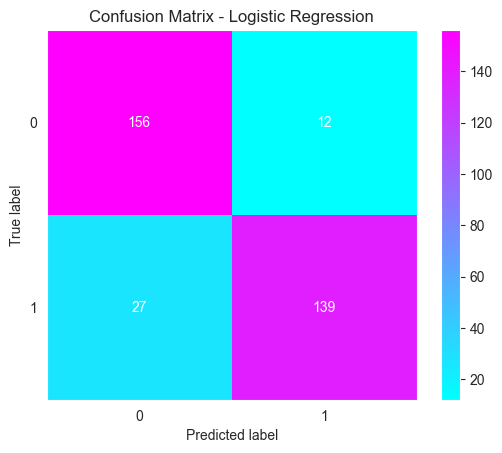


Classification report for Logistic Regression - GS3

               precision    recall  f1-score   support

           0       0.85      0.93      0.89       168
           1       0.92      0.84      0.88       166

    accuracy                           0.88       334
   macro avg       0.89      0.88      0.88       334
weighted avg       0.89      0.88      0.88       334


In [114]:
plot_confusion_matrix(logreg_GS3_predict, y_valid, logreg_GS3, cmap='cool', model_name="Logistic Regression - GS3")

In [115]:
logreg_GS3_df = summarize_score(logreg_GS3_predict, y_valid, "logreg GS3", logreg_hparams3)
logreg_GS3_df

,model,hyperparams,recall,precision,f1-score,number of FN
0,logreg GS3,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.837349,0.92053,0.876972,27


standard predictior

In [116]:
logreg_norm_df = summarize_score(logreg_prediction_valid, y_valid, "logreg norm", None)

In [117]:
logreg_norm_df

,model,hyperparams,recall,precision,f1-score,number of FN
0,logreg norm,None,0.855422,0.904459,0.879257,24


In [118]:
logreg_summary = pd.concat([logreg_norm_df, logreg_GS1_df, logreg_GS2_df, logreg_GS3_df], axis=0)
logreg_summary

,model,hyperparams,recall,precision,f1-score,number of FN
0,logreg norm,None,0.855422,0.904459,0.879257,24
0,logreg GS1,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.843373,0.921053,0.880503,26
0,logreg GS2,"{'C': 110, 'penalty': 'l2', 'solver': 'libline...",0.837349,0.920530,0.876972,27
0,logreg GS3,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.837349,0.920530,0.876972,27


### Ridge Classifier

In [ ]:
ridge_clf = RidgeClassifier(random_state=rand_state)
ridge_clf.fit(X_train, y_train)

In [ ]:
ridge_cv_score_accuracy = cross_val_score(ridge_clf, X_train, y_train, cv=5, scoring='accuracy')
print("average CV-accuracy score of SGDClassifier with 5-fold:", round(sum(ridge_cv_score_accuracy) / len(ridge_cv_score_accuracy), 3))

In [ ]:
ridge_cv_score_recall = cross_val_score(ridge_clf, X_train, y_train, cv=5, scoring='recall')
print("average CV-recall score of SGDClassifier with 5-fold:", round(sum(ridge_cv_score_recall) / len(ridge_cv_score_recall), 3))

In [ ]:
ridge_cv_score_precision = cross_val_score(ridge_clf, X_train, y_train, cv=5, scoring='precision')
print("average CV-precision score of SGDClassifier with 5-fold:", round(sum(ridge_cv_score_precision) / len(ridge_cv_score_precision), 3))